In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
!pip freeze >> requirements.txt

In [3]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = 'cpu'
print(DEVICE)

cpu


In [4]:
from torchvision import transforms

# Пример использования torchvision.transforms для предобработки изображений
tform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Преобразование в тензор
])

In [5]:
# tform = T.Compose([
#     T.Resize((224, 224)),
#     T.RandomHorizontalFlip(), # три функции для аугментации
#     T.RandomRotation(45),
#     T.ColorJitter(brightness=.5, hue=.3),
#     T.ToTensor()
#     ]
# )

In [6]:
train_dataset = torchvision.datasets.ImageFolder(
    '/Users/valeriaalesnikova/Desktop/bootcamp/фаза 2/ds-phase-2/nn-project/coffee-beans/train',
    transform=tform
)
valid_dataset = torchvision.datasets.ImageFolder(
    '/Users/valeriaalesnikova/Desktop/bootcamp/фаза 2/ds-phase-2/nn-project/coffee-beans/test/',
    transform=tform
)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [8]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [9]:
model.to(device=DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
#заменяем последний слой

model.fc = nn.Linear(2048,4)

In [11]:
#замораживаем 

for param in model.parameters():
    param.requires_grad = False
    
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [12]:
#классифицируем

class_dict_coffee= {j: i for i, j in train_dataset.class_to_idx.items()}
class_dict_coffee

{0: 'Dark', 1: 'Green', 2: 'Light', 3: 'Medium'}

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

In [14]:
def torch_train(
        model: nn.Module, 
        epochs: int, 
        optimizer: torch.optim.Optimizer, 
        history = None
        ) -> dict:
    '''
    model: pytorch model - model to train
    epochs: int          - number of epochs
    '''

    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    start_epoch = len(history['train_accs'])
    for epoch in range(start_epoch+1, start_epoch+epochs+1):
        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        model.train()
        batch_accs = []
        batch_losses = [] 
        for samples, labels in train_loader: 
            
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)
            
            y_pred = model(samples)
            

            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            batch_accs.append((y_pred.argmax(axis=1) == labels).cpu().numpy().mean())

        history['train_losses'].append(np.mean(batch_losses))
        history['train_accs'].append(np.mean(batch_accs))

        model.eval()
    
        batch_accs = []
        batch_losses = []
        for samples, labels in valid_loader:
            with torch.no_grad():
                y_pred = model(samples.to(DEVICE))
            loss = criterion(y_pred, labels.to(DEVICE))
            batch_losses.append(loss.item())
            batch_accs.append((y_pred.cpu().argmax(axis=1) == labels.cpu()).numpy().mean())
        history['valid_accs'].append(np.mean(batch_accs))
        history['valid_losses'].append(np.mean(batch_losses))

        print(f'Batch accuracies: {batch_accs}')
        print(f'Batch losses: {batch_losses}')
        
        
        print(
        f'train: accuracy {history["train_accs"][-1]:.4f}, loss {history["train_losses"][-1]:.4f}\n'
        f'valid: accuracy {history["valid_accs"][-1]:.4f}, loss {history["valid_losses"][-1]:.4f}'
        )
        print(f'{"-"*35}')
        print()
    

    return history


# logs = torch_train(model, 10, optimizer)

In [15]:
torch_train(model, 10, optimizer)

------------- Epoch 1 -------------
Batch accuracies: [np.float64(0.75), np.float64(0.796875), np.float64(0.75), np.float64(0.859375), np.float64(0.828125), np.float64(0.84375), np.float64(0.75)]
Batch losses: [0.6228611469268799, 0.7047326564788818, 0.6829804182052612, 0.6788175702095032, 0.6291347742080688, 0.6578953862190247, 0.774666428565979]
train: accuracy 0.8152, loss 0.6190
valid: accuracy 0.7969, loss 0.6787
-----------------------------------

------------- Epoch 2 -------------
Batch accuracies: [np.float64(1.0), np.float64(0.953125), np.float64(0.90625), np.float64(0.984375), np.float64(0.9375), np.float64(0.953125), np.float64(0.9375)]
Batch losses: [0.1544543206691742, 0.2529667615890503, 0.24341633915901184, 0.23678138852119446, 0.23619315028190613, 0.2577340602874756, 0.1993384063243866]
train: accuracy 0.9704, loss 0.1566
valid: accuracy 0.9531, loss 0.2258
-----------------------------------

------------- Epoch 3 -------------
Batch accuracies: [np.float64(1.0), np.

{'train_accs': [np.float64(0.8152412280701755),
  np.float64(0.9703947368421053),
  np.float64(0.9917763157894737),
  np.float64(0.9893092105263158),
  np.float64(0.9947916666666667),
  np.float64(0.9947916666666667),
  np.float64(0.9972587719298246),
  np.float64(0.9991776315789473),
  np.float64(1.0),
  np.float64(0.9975328947368421)],
 'train_losses': [np.float64(0.6190111888082404),
  np.float64(0.1565868254554899),
  np.float64(0.08470660938244116),
  np.float64(0.07720582971447393),
  np.float64(0.05416660971547428),
  np.float64(0.04106193320139458),
  np.float64(0.03657396794541886),
  np.float64(0.03285608430834193),
  np.float64(0.026186493470480566),
  np.float64(0.02431943904804556)],
 'valid_accs': [np.float64(0.796875),
  np.float64(0.953125),
  np.float64(0.9955357142857143),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0)],
 'valid_losses': [np.float64(0.6787269115447998),
  np.float64(0

In [16]:
torch.save(model.state_dict(), 'coffe_save.pt') #сохранили модель

In [17]:
from torchvision.models import vgg19, VGG19_Weights
model_1 = vgg19(weights=VGG19_Weights.DEFAULT)

model_2 = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/valeriaalesnikova/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100.0%


In [27]:
!curl -O https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35363  100 35363    0     0  44720      0 --:--:-- --:--:-- --:--:-- 44706


In [28]:
labels = json.load(open('imagenet_class_index.json'))
decode = lambda x: labels[str(x)][1]

In [29]:
def double_classify(img): 
    model_1.eval()
    model_2.eval()
    pred1 = model_1(img.unsqueeze(0)).softmax(dim=1)
    pred2 = model_2(img.unsqueeze(0)).softmax(dim=1)
    
    pred_vote = (pred1 + pred2)/2
    
    
    sorted, indices = torch.sort(pred_vote, descending=True)
    
    top_5 = sorted.tolist()[0][:5]
    top_5_i = indices.tolist()[0][:5]
    top_5_n = list(map(decode, top_5_i))
    
    return top_5_n, top_5

In [37]:
resize = T.Resize((256, 256))

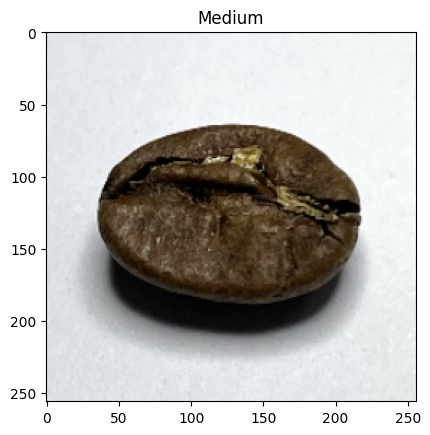

In [43]:
model.eval()
img = resize(io.read_image('/Users/valeriaalesnikova/Desktop/bootcamp/фаза 2/ds-phase-2/nn-project/coffee-beans/test/Medium/medium (2).png')/255)
plt.imshow(torch.permute(img, (1, 2, 0)))
plt.title(class_dict_coffee[model(img.to(DEVICE).unsqueeze(0)).softmax(dim=1).argmax().tolist()]);

(['shower_cap', 'spaghetti_squash', 'rubber_eraser', 'sea_urchin', 'dough'],
 [0.1267952024936676,
  0.08261630684137344,
  0.042115312069654465,
  0.03295475244522095,
  0.028786551207304])

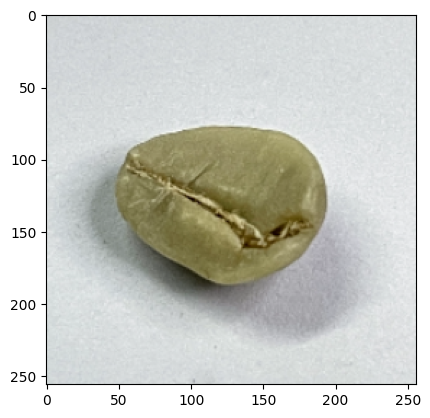

In [41]:
img = resize(io.read_image('/Users/valeriaalesnikova/Desktop/bootcamp/фаза 2/ds-phase-2/nn-project/coffee-beans/test/Green/green (3).png')/255)
plt.imshow(torch.permute(img, (1, 2, 0)))
double_classify(img)